In [1]:

from mpl_toolkits import mplot3d # 三维画图
import numpy as np
%matplotlib inline
import sys
sys.path.append("..") 
import dl_utils
import torch
import torch.optim as optim
import torch.nn as nn


# Optimizer
### 在一个深度学习问题中，我们通常会预先定义一个损失函数。

### 有了损失函数以后，我们就可以使用优化算法试图将其最小化。

在优化中，这样的损失函数通常被称作优化问题的目标函数（objective function）。依据惯例，优化算法通常只考虑最小化目标函数。

这里不考虑 泛化误差和训练误差，只考虑 最小化目标函数的问题。

深度学习中绝大多数目标函数都很复杂。因此，很多优化问题并不存在解析解，而需要使用基于数值方法的优化算法找到近似解，即数值解。本书中讨论的优化算法都是这类基于数值方法的算法。为了求得最小化目标函数的数值解，我们将通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。

优化在深度学习中有很多挑战。下面描述了其中的两个挑战，即局部最小值和鞍点。为了更好地描述问题，我们先导入本节中实验需要的包或模块。

## 局部最小值

对于目标函数$f(x)$，如果$f(x)$在$x$上的值比在$x$邻近的其他点的值更小，那么$f(x)$可能是一个局部最小值（local minimum）。如果$f(x)$在$x$上的值是目标函数在整个定义域上的最小值，那么$f(x)$是全局最小值（global minimum）。

举个例子，给定函数
$$
f(x) = x \cdot \text{cos}(\pi x), \qquad -1.0 \leq x \leq 2.0,
$$
我们可以大致找出该函数的局部最小值和全局最小值的位置。需要注意的是，图中箭头所指示的只是大致位置。

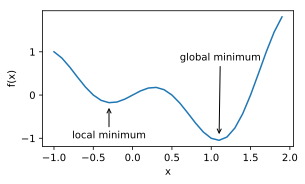

In [2]:
def f(x):
    return x * np.cos(np.pi * x)

dl_utils.set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig,  = dl_utils.plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                  arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
                  arrowprops=dict(arrowstyle='->'))
dl_utils.plt.xlabel('x')
dl_utils.plt.ylabel('f(x)');

深度学习模型的目标函数可能有若干局部最优值。当一个优化问题的数值解在局部最优解附近时，由于目标函数有关解的梯度接近或变成零，最终迭代求得的数值解可能只令目标函数局部最小化而非全局最小化。

###  鞍点

刚刚我们提到，**梯度接近或变成零**可能是由于当前解在局部最优解附近造成的。事实上，另一种可能性是当前解在鞍点（saddle point）附近。

举个例子，给定函数

$$f(x) = x^3,$$

我们可以找出该函数的鞍点位置。

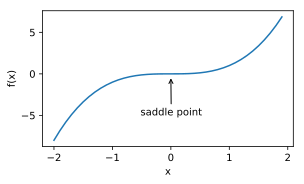

In [3]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = dl_utils.plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.3), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
dl_utils.plt.xlabel('x')
dl_utils.plt.ylabel('f(x)');

再举个定义在二维空间的函数的例子，例如：

$$f(x, y) = x^2 - y^2.$$

我们可以找出该函数的鞍点位置。也许你已经发现了，该函数看起来像一个马鞍，而鞍点恰好是马鞍上可坐区域的中心。

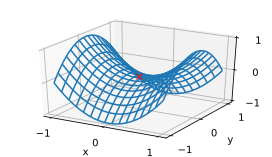

In [4]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

ax = dl_utils.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'rx')
ticks = [-1,  0, 1]
dl_utils.plt.xticks(ticks)
dl_utils.plt.yticks(ticks)
ax.set_zticks(ticks)
dl_utils.plt.xlabel('x')
dl_utils.plt.ylabel('y');

在图的鞍点位置，目标函数在$x$轴方向上是局部最小值，但在$y$轴方向上是局部最大值。

假设一个函数的输入为$k$维向量，输出为标量，那么它的海森矩阵（Hessian matrix）有$k$个特征值。该函数在梯度为0的位置上可能是局部最小值、局部最大值或者鞍点。

- 当函数的海森矩阵在梯度为零的位置上的特征值全为正时，该函数得到局部最小值。
- 当函数的海森矩阵在梯度为零的位置上的特征值全为负时，该函数得到局部最大值。
- 当函数的海森矩阵在梯度为零的位置上的特征值有正有负时，该函数得到鞍点。

随机矩阵理论告诉我们，对于一个大的高斯随机矩阵来说，任一特征值是正或者是负的概率都是0.5 [1]。那么，以上第一种情况的概率为 $0.5^k$。由于深度学习模型参数通常都是高维的（$k$很大），目标函数的鞍点通常比局部最小值更常见。

在深度学习中，虽然找到目标函数的全局最优解很难，但这并非必要。我们将在本章接下来的几节中逐一介绍深度学习中常用的优化算法，它们在很多实际问题中都能够训练出十分有效的深度学习模型。

## 小结

- 由于优化算法的目标函数通常是一个基于训练数据集的损失函数，优化的目标在于降低训练误差。
- 由于深度学习模型参数通常都是高维的，目标函数的鞍点通常比局部最小值更常见。

## 参考文献

[1] Wigner, E. P. (1958). On the distribution of the roots of certain symmetric matrices. Annals of Mathematics, 325-327.

# 梯度下降和随机梯度下降

绍梯度下降（gradient descent）,虽然梯度下降在深度学习中很少被直接使用，但理解

**梯度的意义**以及**沿着梯度反方向更新自变量**可能降低目标函数值的原因是学习后续优化算法的基础。随后，我们将引出随机梯度下降（stochastic gradient descent）。

##  一维梯度下降

我们先以简单的一维梯度下降为例，解释梯度下降算法可能降低目标函数值的原因。假设连续可导的函数$f: \mathbb{R} \rightarrow \mathbb{R}$的输入和输出都是标量。给定绝对值足够小的数$\epsilon$，根据泰勒展开公式，我们得到以下的近似：

$$f(x + \epsilon) \approx f(x) + \epsilon f'(x) .$$

这里$f'(x)$是函数$f$在$x$处的梯度。一维函数的梯度是一个标量，也称导数。

接下来，找到一个常数$\eta > 0$，使得$\left|\eta f'(x)\right|$足够小，那么可以将$\epsilon$替换为$-\eta f'(x)$并得到

$$f(x - \eta f'(x)) \approx f(x) -  \eta f'(x)^2.$$

如果导数$f'(x) \neq 0$，那么$\eta f'(x)^2>0$，所以

$$f(x - \eta f'(x)) \lesssim f(x).$$

这意味着，如果通过

$$x \leftarrow x - \eta f'(x)$$

来迭代$x$，函数$f(x)$的值可能会降低。因此在梯度下降中，我们先选取一个初始值$x$和常数$\eta > 0$，然后不断通过上式来迭代$x$，直到达到停止条件，例如$f'(x)^2$的值已足够小或迭代次数已达到某个值。

下面我们以目标函数$f(x)=x^2$为例来看一看梯度下降是如何工作的。虽然我们知道最小化$f(x)$的解为$x=0$，这里依然使用这个简单函数来观察$x$是如何被迭代的。首先，导入本节实验所需的包或模块。

接下来使用$x=10$作为初始值，并设$\eta=0.2$。使用梯度下降对$x$迭代10次，可见最终$x$的值较接近最优解。

In [5]:
import math
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * 2 * x  # f(x) = x * x的导数为f'(x) = 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)


epoch 10, x: 0.06046617599999997


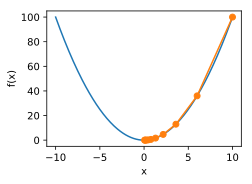

In [6]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.1)
    dl_utils.set_figsize()
    dl_utils.plt.plot(f_line, [x * x for x in f_line])
    dl_utils.plt.plot(res, [x * x for x in res], '-o')
    dl_utils.plt.xlabel('x')
    dl_utils.plt.ylabel('f(x)')

show_trace(res)

## 学习率

上述梯度下降算法中的正数$\eta$通常叫作学习率。这是一个超参数，需要人工设定。如果使用过小的学习率，会导致$x$更新缓慢从而需要更多的迭代才能得到较好的解。

下面展示使用学习率$\eta=0.05$时自变量$x$的迭代轨迹。可见，同样迭代10次后，当学习率过小时，最终$x$的值依然与最优解存在较大偏差。

epoch 10, x: 3.4867844009999995


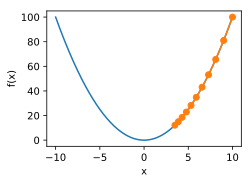

In [7]:
show_trace(gd(0.05))

如果使用过大的学习率，$\left|\eta f'(x)\right|$可能会过大从而使前面提到的一阶泰勒展开公式不再成立：这时我们无法保证迭代$x$会降低$f(x)$的值。

举个例子，当设学习率$\eta=1.1$时，可以看到$x$不断越过（overshoot）最优解$x=0$并逐渐发散。




epoch 10, x: 61.917364224000096


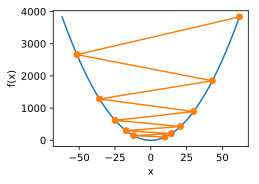

In [8]:
show_trace(gd(1.1))

## 多维梯度下降

在了解了一维梯度下降之后，我们再考虑一种更广义的情况：目标函数的输入为向量，输出为标量。假设目标函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的输入是一个$d$维向量$\boldsymbol{x} = [x_1, x_2, \ldots, x_d]^\top$。目标函数$f(\boldsymbol{x})$有关$\boldsymbol{x}$的梯度是一个由$d$个偏导数组成的向量：

$$\nabla_{\boldsymbol{x}} f(\boldsymbol{x}) = \bigg[\frac{\partial f(\boldsymbol{x})}{\partial x_1}, \frac{\partial f(\boldsymbol{x})}{\partial x_2}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_d}\bigg]^\top.$$

为表示简洁，我们用$\nabla f(\boldsymbol{x})$代替$\nabla_{\boldsymbol{x}} f(\boldsymbol{x})$。梯度中每个偏导数元素$\partial f(\boldsymbol{x})/\partial x_i$代表着$f$在$\boldsymbol{x}$有关输入$x_i$的变化率。为了测量$f$沿着单位向量$\boldsymbol{u}$（即$\|\boldsymbol{u}\|=1$）方向上的变化率，在多元微积分中，我们定义$f$在$\boldsymbol{x}$上沿着$\boldsymbol{u}$方向的方向导数为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \lim_{h \rightarrow 0}  \frac{f(\boldsymbol{x} + h \boldsymbol{u}) - f(\boldsymbol{x})}{h}.$$

依据方向导数性质[1，14.6节定理三]，以上方向导数可以改写为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \nabla f(\boldsymbol{x}) \cdot \boldsymbol{u}.$$

方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$给出了$f$在$\boldsymbol{x}$上沿着所有可能方向的变化率。为了最小化$f$，我们希望找到$f$能被降低最快的方向。因此，我们可以通过单位向量$\boldsymbol{u}$来最小化方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$。

由于$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \|\nabla f(\boldsymbol{x})\| \cdot \|\boldsymbol{u}\|  \cdot \text{cos} (\theta) = \|\nabla f(\boldsymbol{x})\|  \cdot \text{cos} (\theta)$，
其中$\theta$为梯度$\nabla f(\boldsymbol{x})$和单位向量$\boldsymbol{u}$之间的夹角，当$\theta = \pi$时，$\text{cos}(\theta)$取得最小值$-1$。因此，当$\boldsymbol{u}$在梯度方向$\nabla f(\boldsymbol{x})$的相反方向时，方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$被最小化。因此，我们可能通过梯度下降算法来不断降低目标函数$f$的值：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f(\boldsymbol{x}).$$

同样，其中$\eta$（取正数）称作学习率。

下面我们构造一个输入为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和输出为标量的目标函数$f(\boldsymbol{x})=x_1^2+2x_2^2$。那么，梯度$\nabla f(\boldsymbol{x}) = [2x_1, 4x_2]^\top$。我们将观察梯度下降从初始位置$[-5,-2]$开始对自变量$\boldsymbol{x}$的迭代轨迹。我们先定义两个辅助函数，第一个函数使用给定的自变量更新函数，从初始位置$[-5,-2]$开始迭代自变量$\boldsymbol{x}$共20次，第二个函数对自变量$\boldsymbol{x}$的迭代轨迹进行可视化。

In [9]:
import matplotlib.pyplot as plt
def train_2d(trainer):  # 本函数将保存在d2lzh_pytorch包中方便以后使用
    x1, x2, s1, s2 = -5, -2, 0, 0  # s1和s2是自变量状态，本章后续几节会使用
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):  # 本函数将保存在d2lzh_pytorch包中方便以后使用
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')

epoch 20, x1 -0.057646, x2 -0.000073


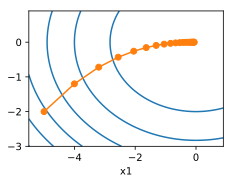

In [10]:
eta = 0.1

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

## 随机梯度下降

在深度学习里，目标函数通常是训练数据集中有关各个样本的损失函数的平均。设$f_i(\boldsymbol{x})$是有关索引为$i$的训练数据样本的损失函数，$n$是训练数据样本数，$\boldsymbol{x}$是模型的参数向量，那么目标函数定义为

$$f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\boldsymbol{x}).$$

目标函数在$\boldsymbol{x}$处的梯度计算为

$$\nabla f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}).$$

如果使用梯度下降，每次自变量迭代的计算开销为$\mathcal{O}(n)$，它随着$n$线性增长。因此，当训练数据样本数很大时，梯度下降每次迭代的计算开销很高。

**随机梯度下降（stochastic gradient descent，SGD）减少了每次迭代的计算开销。在随机梯度下降的每次迭代中，我们随机均匀采样的一个样本索引$i\in\{1,\ldots,n\}$，并计算梯度$\nabla f_i(\boldsymbol{x})$来迭代$\boldsymbol{x}$：**

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f_i(\boldsymbol{x}).$$

这里$\eta$同样是学习率。可以看到每次迭代的计算开销从梯度下降的$\mathcal{O}(n)$降到了常数$\mathcal{O}(1)$。值得强调的是，随机梯度$\nabla f_i(\boldsymbol{x})$是对梯度$\nabla f(\boldsymbol{x})$的无偏估计：

$$E_i \nabla f_i(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}) = \nabla f(\boldsymbol{x}).$$

这意味着，平均来说，随机梯度是对梯度的一个良好的估计。

下面我们通过在梯度中添加均值为0的随机噪声来模拟随机梯度下降，以此来比较它与梯度下降的区别。

epoch 20, x1 -0.019040, x2 -0.119766


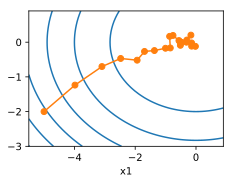

In [11]:
def sgd_2d(x1, x2, s1, s2):
    return (x1 - eta * (2 * x1 + np.random.normal(0.1)),
            x2 - eta * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

可以看到，随机梯度下降中自变量的迭代轨迹相对于梯度下降中的来说更为曲折。这是由于实验所添加的噪声使模拟的随机梯度的准确度下降。在实际中，这些噪声通常指训练数据集中的无意义的干扰。

## 小结

- 使用适当的学习率，沿着梯度反方向更新自变量可能降低目标函数值。梯度下降重复这一更新过程直到得到满足要求的解。
- 学习率过大或过小都有问题。一个合适的学习率通常是需要通过多次实验找到的。
- 当训练数据集的样本较多时，梯度下降每次迭代的计算开销较大，因而随机梯度下降通常更受青睐。

## 参考文献

[1] Stewart, J. (2010). Calculus: early transcendentals. 7th ed. Cengage Learning.

------

# mini -batch SGD 小批量随机梯度下降

1. 梯度下降使用整个训练数据集来计算梯度，因此它有时也被称为批量梯度下降（batch gradient descent）
2. 随机梯度下降 SGD 在每次迭代中只随机采样一个样本来计算梯度。
3. 我们还可以在每轮迭代中随机均匀采样多个样本来组成一个小批量，然后使用这个小批量来计算梯度。 mini-batch gradient descent

下面就来描述小批量随机梯度下降。


设目标函数$f(\boldsymbol{x}): \mathbb{R}^d \rightarrow \mathbb{R}$。在迭代开始前的时间步设为0。该时间步的自变量记为$\boldsymbol{x}_0\in \mathbb{R}^d$，通常由随机初始化得到。在接下来的每一个时间步$t>0$中，小批量随机梯度下降随机均匀采样一个由训练数据样本索引组成的小批量$\mathcal{B}_t$。我们可以通过重复采样（sampling with replacement）或者不重复采样（sampling without replacement）得到一个小批量中的各个样本。前者允许同一个小批量中出现重复的样本，后者则不允许如此，且更常见。对于这两者间的任一种方式，都可以使用
$$
\boldsymbol{g}_t \leftarrow \nabla f_{\mathcal{B}_t}(\boldsymbol{x}_{t-1}) = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t}\nabla f_i(\boldsymbol{x}_{t-1})
$$
来计算时间步$t$的小批量$\mathcal{B}_t$上目标函数位于$\boldsymbol{x}_{t-1}$处的梯度$\boldsymbol{g}_t$。这里$|\mathcal{B}|$代表批量大小，即小批量中样本的个数，是一个超参数。同随机梯度一样，重复采样所得的小批量随机梯度$\boldsymbol{g}_t$也是对梯度$\nabla f(\boldsymbol{x}_{t-1})$的无偏估计。给定学习率$\eta_t$（取正数），小批量随机梯度下降对自变量的迭代如下：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \eta_t \boldsymbol{g}_t.$$

基于随机采样得到的梯度的方差在迭代过程中无法减小，因此在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减，例如$\eta_t=\eta t^\alpha$（通常$\alpha=-1$或者$-0.5$）、$\eta_t = \eta \alpha^t$（如$\alpha=0.95$）或者每迭代若干次后将学习率衰减一次。如此一来，学习率和（小批量）随机梯度乘积的方差会减小。而梯度下降在迭代过程中一直使用目标函数的真实梯度，无须自我衰减学习率。

小批量随机梯度下降中每次迭代的计算开销为$\mathcal{O}(|\mathcal{B}|)$。当批量大小为1时，该算法即为随机梯度下降；当批量大小等于训练数据样本数时，该算法即为梯度下降。当批量较小时，每次迭代中使用的样本少，这会导致并行处理和内存使用效率变低。这使得在计算同样数目样本的情况下比使用更大批量时所花时间更多。当批量较大时，每个小批量梯度里可能含有更多的冗余信息。为了得到较好的解，批量较大时比批量较小时需要计算的样本数目可能更多，例如增大迭代周期数。

In [12]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim

In [14]:
def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('../Data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
    torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape # torch.Size([1500, 5])

torch.Size([1500, 5])

loss: 0.245300, 0.063829 sec per epoch


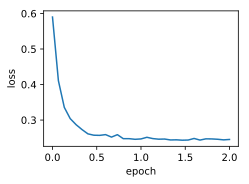

In [15]:
# 例如: optimizer_fn=torch.optim.SGD, optimizer_hyperparams={"lr": 0.05}
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    dl_utils.set_figsize()
    dl_utils.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    dl_utils.plt.xlabel('epoch')
    dl_utils.plt.ylabel('loss')

train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)

## 小结

- 小批量随机梯度每次随机均匀采样一个小批量的训练样本来计算梯度。
- 在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减。
- 通常，小批量随机梯度在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。

#  动量法

在7.2节（梯度下降和随机梯度下降）中我们提到，目标函数有关自变量的梯度代表了目标函数在自变量当前位置下降最快的方向。因此，梯度下降也叫作最陡下降（steepest descent）。在每次迭代中，梯度下降根据自变量当前位置，沿着当前位置的梯度更新自变量。然而，如果自变量的迭代方向仅仅取决于自变量当前位置，这可能会带来一些问题。

动量法的提出是为了解决梯度下降的上述问题。由于小批量随机梯度下降比梯度下降更为广义，本章后续讨论将沿用7.3节（小批量随机梯度下降）中时间步$t$的小批量随机梯度$\boldsymbol{g}_t$的定义。设时间步$t$的自变量为$\boldsymbol{x}_t$，学习率为$\eta_t$。
在时间步$0$，动量法创建速度变量$\boldsymbol{v}_0$，并将其元素初始化成0。在时间步$t>0$，动量法对每次迭代的步骤做如下修改：
$$
\begin{aligned}
\boldsymbol{v}_t &\leftarrow \gamma \boldsymbol{v}_{t-1} + \eta_t \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{v}_t,
\end{aligned}
$$
其中，动量超参数$\gamma$满足$0 \leq \gamma < 1$。当$\gamma=0$时，动量法等价于小批量随机梯度下降。

### 指数加权移动平均

为了从数学上理解动量法，让我们先解释一下指数加权移动平均（exponentially weighted moving average）。给定超参数$0 \leq \gamma < 1$，当前时间步$t$的变量$y_t$是上一时间步$t-1$的变量$y_{t-1}$和当前时间步另一变量$x_t$的线性组合：

$$y_t = \gamma y_{t-1} + (1-\gamma) x_t.$$

我们可以对$y_t$展开：
$$
\begin{aligned}
y_t  &= (1-\gamma) x_t + \gamma y_{t-1}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + \gamma^2y_{t-2}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + (1-\gamma) \cdot \gamma^2x_{t-2} + \gamma^3y_{t-3}\\
         &\ldots
\end{aligned}
$$
令$n = 1/(1-\gamma)$，那么 $\left(1-1/n\right)^n = \gamma^{1/(1-\gamma)}$。因为

$$ \lim_{n \rightarrow \infty}  \left(1-\frac{1}{n}\right)^n = \exp(-1) \approx 0.3679,$$

所以当$\gamma \rightarrow 1$时，$\gamma^{1/(1-\gamma)}=\exp(-1)$，如$0.95^{20} \approx \exp(-1)$。如果把$\exp(-1)$当作一个比较小的数，我们可以在近似中忽略所有含$\gamma^{1/(1-\gamma)}$和比$\gamma^{1/(1-\gamma)}$更高阶的系数的项。例如，当$\gamma=0.95$时，

$$y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}.$$

因此，在实际中，我们常常将$y_t$看作是对最近$1/(1-\gamma)$个时间步的$x_t$值的加权平均。例如，当$\gamma = 0.95$时，$y_t$可以被看作对最近20个时间步的$x_t$值的加权平均；当$\gamma = 0.9$时，$y_t$可以看作是对最近10个时间步的$x_t$值的加权平均。而且，离当前时间步$t$越近的$x_t$值获得的权重越大（越接近1）。

###  由指数加权移动平均理解动量法

现在，我们对动量法的速度变量做变形：

$$\boldsymbol{v}_t \leftarrow \gamma \boldsymbol{v}_{t-1} + (1 - \gamma) \left(\frac{\eta_t}{1 - \gamma} \boldsymbol{g}_t\right). $$

由指数加权移动平均的形式可得，速度变量$\boldsymbol{v}_t$实际上对序列$\{\eta_{t-i}\boldsymbol{g}_{t-i} /(1-\gamma):i=0,\ldots,1/(1-\gamma)-1\}$做了指数加权移动平均。换句话说，相比于小批量随机梯度下降，**动量法在每个时间步的自变量更新量近似于将最近$1/(1-\gamma)$个时间步的普通更新量（即学习率乘以梯度）做了指数加权移动平均后再除以$1-\gamma$**。所以，在动量法中，自变量在各个方向上的移动幅度不仅取决当前梯度，还取决于过去的各个梯度在各个方向上是否一致。在本节之前示例的优化问题中，所有梯度在水平方向上为正（向右），而在竖直方向上时正（向上）时负（向下）。这样，我们就可以使用较大的学习率，从而使自变量向最优解更快移动。

loss: 0.255635, 0.065848 sec per epoch


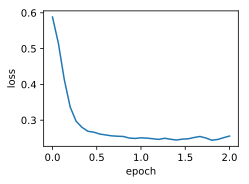

In [16]:
train_pytorch_ch7(torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9},
                    features, labels)

## 小结

- 动量法使用了指数加权移动平均的思想。它将过去时间步的梯度做了加权平均，且权重按时间步指数衰减。
- 动量法使得相邻时间步的自变量更新在方向上更加一致。

AdaGrad算法
RMSProp算法   
AdaDelta算法  
Adam算法